# Part 1: Setting up a basic semantic search system

A big thank you to [David on Github](https://github.com/gypsydave5) for finding a bug in my analysis code and bringing it to my attention. The bug was resolved! 

Some numbers might be different from what is reported in the book/video course but the overall gist is the same: re-ranking helps our semantic search and fine-tuning the re-ranking cross encoder yielded even better results.

In [ ]:
%pip install pinecone openai sentence-transformers tiktoken datasets

In [ ]:
from openai import OpenAI
from datetime import datetime, timezone
import hashlib
import re
import os
from sentence_transformers import CrossEncoder


from tqdm import tqdm
import numpy as np
from torch import nn

import logging
from pinecone import Pinecone, ServerlessSpec

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


In [4]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

INDEX_NAME = 'semantic-search-test'
NAMESPACE = 'default'
ENGINE = 'text-embedding-3-large'  # has vector size 3072

pc = Pinecone(
    api_key=pinecone_key
)

In [5]:
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]

len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(3072, 2)

In [ ]:
if INDEX_NAME not in pc.list_indexes().names():
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=3072,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [8]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [ ]:
def prepare_for_pinecone(texts, engine=ENGINE):
    # Get the current UTC date and time
    now = datetime.now(timezone.utc).isoformat()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    return [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]


In [10]:
texts = ['hi']

In [11]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  3072 
META: {'text': 'hi', 'date_uploaded': datetime.datetime(2025, 2, 9, 1, 36, 34, 26529)}


In [12]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        batch = texts[i: i + batch_size]
        prepared_texts = prepare_for_pinecone(batch)

        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)


1

In [13]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [14]:
def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

In [15]:
from datasets import load_dataset

dataset = load_dataset("xtreme", "MLQA.en.en")

# rename test -> train and val -> test (as we will use it in later in this chapter)
dataset['train'] = dataset['test']
dataset['test'] = dataset['validation']
del dataset['validation']

dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1148
    })
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11590
    })
})

In [16]:
dataset['train'][0], dataset['train'][1]

({'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
  'title': 'Area 51',
  'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its dut

In [17]:
unique_passages = list(set(dataset['test']['context']))
for idx in tqdm(range(0, len(unique_passages), 32)):
    passages = unique_passages[idx:idx + 32]
    upload_texts_to_pinecone(passages)


100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


In [18]:
len(unique_passages)

978

In [19]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 979}},
 'total_vector_count': 979}

In [20]:
dataset['test'][0]

{'id': '569666f4dc3983dab5624e989212c1d9d0cd1798',
 'title': 'Pappataci fever',
 'context': 'Pappataci fever is prevalent in the subtropical zone of the Eastern Hemisphere between 20°N and 45°N, particularly in Southern Europe, North Africa, the Balkans, Eastern Mediterranean, Iraq, Iran, Pakistan, Afghanistan and India.The disease is transmitted by the bites of phlebotomine sandflies of the Genus Phlebotomus, in particular, Phlebotomus papatasi, Phlebotomus perniciosus and Phlebotomus perfiliewi. The sandfly becomes infected when biting an infected human in the period between 48 hours before the onset of fever and 24 hours after the end of the fever, and remains infected for its lifetime. Besides this horizontal virus transmission from man to sandfly, the virus can be transmitted in insects transovarially, from an infected female sandfly to its offspring.Pappataci fever is seldom recognised in endemic populations because it is mixed with other febrile illnesses of childhood, but it is

In [21]:
query_from_pinecone('Does an infection for Sandflies go away over time?')

[{'id': '2f90090e21f19450887d5f3ff781e541',
  'metadata': {'date_uploaded': '2025-02-09T01:36:44.647948',
               'text': 'Pappataci fever is prevalent in the subtropical zone of '
                       'the Eastern Hemisphere between 20°N and 45°N, '
                       'particularly in Southern Europe, North Africa, the '
                       'Balkans, Eastern Mediterranean, Iraq, Iran, Pakistan, '
                       'Afghanistan and India.The disease is transmitted by the '
                       'bites of phlebotomine sandflies of the Genus '
                       'Phlebotomus, in particular, Phlebotomus papatasi, '
                       'Phlebotomus perniciosus and Phlebotomus perfiliewi. The '
                       'sandfly becomes infected when biting an infected human '
                       'in the period between 48 hours before the onset of '
                       'fever and 24 hours after the end of the fever, and '
                       'remains infec

# Part 2: Making results more relevant with a cross-encoder

In [22]:
# if you didn't import before

from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
from torch import nn

In [23]:
from copy import copy

def get_results_from_pinecone(query, top_k=3, re_rank_model=None, verbose=True, correct_hash=None):

    results_from_pinecone = query_from_pinecone(query, top_k=top_k)

    if not results_from_pinecone:
        return []

    if verbose:
        print("Query:", query)


    final_results = []

    retrieved_correct_position, reranked_correct_position = None, None
    for idx, result_from_pinecone in enumerate(results_from_pinecone):
        if correct_hash and result_from_pinecone['id'] == correct_hash:
            retrieved_correct_position = idx

    if re_rank_model is not None:
        if verbose:
            print('Document ID (Hash)\t\tRetrieval Score\tCE Score\tText')

        sentence_combinations = [[query, result_from_pinecone['metadata']['text']] for result_from_pinecone in results_from_pinecone]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        sim_scores_sort = list(reversed(np.sort(similarity_scores)))
        top_re_rank_score = sim_scores_sort[0]

        # Print the scores
        # print(list(zip(sim_scores_argsort, sim_scores_sort)))
        for idx, _ in enumerate(sim_scores_argsort):
            result_from_pinecone = results_from_pinecone[_]
            if correct_hash and retrieved_correct_position == _:
                reranked_correct_position = idx
            final_results.append({'score': similarity_scores[idx], 'id': result_from_pinecone['id'], 'metadata': result_from_pinecone['metadata']})
            if verbose:
                print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{similarity_scores[idx]:.6f}\t{result_from_pinecone['metadata']['text'][:50]}")
        return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position, 'results_from_pinecone': results_from_pinecone, 'top_re_rank_score': top_re_rank_score}

    if verbose:
        print('Document ID (Hash)\t\tRetrieval Score\tText')
    for result_from_pinecone in results_from_pinecone:
        final_results.append(result_from_pinecone)
        if verbose:
            print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")

    return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position}

In [24]:
# Pre-trained cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', num_labels=1)

q_to_hash = {data['question']: my_hash(data['context']) for data in dataset['test']}

In [25]:
unique_inputs = list(set(dataset['test']['question']))
len(unique_inputs)

1148

In [26]:
query = unique_inputs[0]
print(query)

for t in dataset['test']:
    if t['question'] == query:
        print(t['context'])

What was the year range?
Of Natures Obvious Laws & Processes in Vegetation (unpublished, c. 1671–75)


In [27]:
query_result = get_results_from_pinecone(
    query,
    top_k=2, # grab 2 results
    re_rank_model=cross_encoder,
    correct_hash=q_to_hash[query],
    verbose=False
    )

query_result['retrieved_correct_position'], query_result['reranked_correct_position']

(None, None)

In [28]:
query_result  # the right context isn't there!

{'final_results': [{'score': 0.00039841508,
   'id': '7760dbdfeaf1828b780539812180a8a3',
   'metadata': {'date_uploaded': '2025-02-09T01:36:58.059608',
    'text': "In the middle of the 18th century, a series of colonial conflicts began between France and Britain, which ultimately resulted in the destruction of most of the first French colonial empire and the near-complete expulsion of France from the Americas. These wars were the War of the Austrian Succession (1740–1748), the Seven Years' War (1756–1763), the American Revolution (1765–1783), the French Revolutionary Wars (1793–1802) and the Napoleonic Wars (1803–1815). It may even be seen further back in time to the first of the French and Indian Wars. This cyclic conflict is sometimes known as the Second Hundred Years' War."}},
  {'score': 0.0002454633,
   'id': '517f23b9677bddd92be1e469c9182d88',
   'metadata': {'date_uploaded': '2025-02-09T01:37:12.088736',
    'text': 'From 1972, the National Park Service began allowing natural f

In [29]:
query_result = get_results_from_pinecone(
    query,
    top_k=100, # grab 10 results
    re_rank_model=cross_encoder, correct_hash=q_to_hash[query],
    verbose=False
    )

query_result['retrieved_correct_position'], query_result['reranked_correct_position']

(None, None)

In [30]:
test_sample = dataset['test']

In [31]:
TOP_K=50

In [32]:
logger.setLevel(logging.CRITICAL)

predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=cross_encoder, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    predictions.append(r)
    if len(predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions])/len(predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions])/len(predictions)

        print(f'Accuracy without re-ranking: {retrieved_accuracy}')
        print(f'Accuracy with re-ranking: {re_ranked_accuracy}')


  9%|▊         | 100/1148 [01:34<16:24,  1.06it/s]

Accuracy without re-ranking: 0.78
Accuracy with re-ranking: 0.84


 17%|█▋        | 200/1148 [03:06<14:30,  1.09it/s]

Accuracy without re-ranking: 0.765
Accuracy with re-ranking: 0.835


 26%|██▌       | 300/1148 [04:42<14:16,  1.01s/it]

Accuracy without re-ranking: 0.7666666666666667
Accuracy with re-ranking: 0.8166666666666667


 35%|███▍      | 400/1148 [06:18<11:20,  1.10it/s]

Accuracy without re-ranking: 0.7625
Accuracy with re-ranking: 0.8275


 44%|████▎     | 500/1148 [07:53<10:14,  1.05it/s]

Accuracy without re-ranking: 0.764
Accuracy with re-ranking: 0.836


 52%|█████▏    | 600/1148 [09:32<08:52,  1.03it/s]

Accuracy without re-ranking: 0.7683333333333333
Accuracy with re-ranking: 0.8483333333333334


 61%|██████    | 700/1148 [11:06<07:11,  1.04it/s]

Accuracy without re-ranking: 0.7471428571428571
Accuracy with re-ranking: 0.83


 70%|██████▉   | 800/1148 [12:45<05:23,  1.08it/s]

Accuracy without re-ranking: 0.74875
Accuracy with re-ranking: 0.8225


 78%|███████▊  | 900/1148 [14:26<03:56,  1.05it/s]

Accuracy without re-ranking: 0.7377777777777778
Accuracy with re-ranking: 0.82


 87%|████████▋ | 1000/1148 [16:02<02:28,  1.01s/it]

Accuracy without re-ranking: 0.74
Accuracy with re-ranking: 0.82


 96%|█████████▌| 1100/1148 [17:42<00:46,  1.04it/s]

Accuracy without re-ranking: 0.75
Accuracy with re-ranking: 0.8281818181818181


100%|██████████| 1148/1148 [18:28<00:00,  1.04it/s]


In [33]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions])/len(predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions])/len(predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7534843205574913
Accuracy with re-ranking: 0.8336236933797909


In [34]:
import pandas as pd

predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone,top_re_rank_score
0,"[{'score': 0.29227442, 'id': '2f90090e21f19450...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '...",0.292274
1,"[{'score': 0.17795162, 'id': '49201636ad410273...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '...",0.177952
2,"[{'score': 0.9939328, 'id': '80d92494d2b06f341...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '...",0.993933
3,"[{'score': 0.16567454, 'id': '99247f2042d1ed0b...",0.0,2.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '...",0.848871
4,"[{'score': 0.8213388, 'id': '37ed40c20d4e1b9cc...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '...",0.821339


In [35]:
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()  # lower is better

,0
retrieved_correct_position,1.306595
reranked_correct_position,0.680927


In [36]:
# do recall @ 1, 3, 5, 10, etc
X = [1, 3, 5, 10, 25, 50]
OPENAI_RETRIEVAL = []
OLD_CROSS_ENCODER = []

for k in X:
    embedding_only_recall = predictions_df[predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = predictions_df[predictions_df['reranked_correct_position'] < k].shape[0]
    OPENAI_RETRIEVAL.append(embedding_only_recall / predictions_df.shape[0])
    OLD_CROSS_ENCODER.append(reranked_recall / predictions_df.shape[0])
    print(k, embedding_only_recall, reranked_recall)

1 865 957
3 1009 1057
5 1048 1076
10 1073 1094
25 1108 1120
50 1122 1122


## OPEN SOURCE ALTERNATIVE TO EMBEDDING

In [37]:
from sentence_transformers import SentenceTransformer
# load up our open source embedding model
bi_encoder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# bi_encoder = SentenceTransformer("sentence-transformers/msmarco-MiniLM-L-6-v3")

In [38]:
#Encode query and documents
docs = dataset['test']['context']
doc_emb = bi_encoder.encode(docs, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [39]:
doc_emb.shape

(1148, 768)

In [40]:
from sentence_transformers.util import semantic_search

# Function to find most similar document
def find_most_similar(embedder, text, embeddings, documents, k=3):
    query_embedding = embedder.encode([text], show_progress_bar=False)
    similarities = semantic_search(query_embedding, embeddings, top_k=k)
    return [(documents[sim['corpus_id']], sim['score'], sim['corpus_id']) for sim in similarities[0]]

In [41]:
from random import sample

query = sample(dataset['test']['question'], 1)[0]
print(query)

Who interrogated Saint Valentine?


In [42]:
def eval_ranking_open_source(embedder, doc_emb, query, top_k=3, re_rank_model=None):
    ans = {'retrieved_correct_position': None}
    correct_hash = q_to_hash[query]
    results = find_most_similar(embedder, query, doc_emb, docs, k=top_k)
    for idx, (passage, score, doc_idx) in enumerate(results):
        if correct_hash == my_hash(passage):
            ans['retrieved_correct_position'] =  idx
    if re_rank_model is not None:
        ans['reranked_correct_position'] = None
        sentence_combinations = [(query, r[0]) for r in results]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for i, idx in enumerate(sim_scores_argsort):
            r = results[idx]
            if correct_hash and my_hash(r[0]) == correct_hash:
                ans['reranked_correct_position'] = i

    return ans

In [43]:
eval_ranking_open_source(bi_encoder, doc_emb, query, top_k=TOP_K, re_rank_model=cross_encoder)

{'retrieved_correct_position': 1, 'reranked_correct_position': 1}

In [44]:
logger.setLevel(logging.CRITICAL)
os_predictions = []

for i, question in tqdm(enumerate(test_sample), total=len(test_sample)):
    os_predictions.append(eval_ranking_open_source(bi_encoder, doc_emb, question['question'], top_k=TOP_K, re_rank_model=cross_encoder))

100%|██████████| 1148/1148 [09:03<00:00,  2.11it/s]


In [45]:
os_predictions_df = pd.DataFrame(os_predictions)
os_predictions_df.head()

,retrieved_correct_position,reranked_correct_position
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [46]:
raw_accuracy = sum([p['retrieved_correct_position'] == 0 for p in os_predictions])/len(os_predictions)
reranked_accuracy = sum([p['reranked_correct_position'] == 0 for p in os_predictions])/len(os_predictions)

print(f'Accuracy without re-ranking: {raw_accuracy}')
print(f'Accuracy with re-ranking: {reranked_accuracy}')


Accuracy without re-ranking: 0.5017421602787456
Accuracy with re-ranking: 0.6202090592334495


In [47]:
# do recall @ 1, 3, 5, 10
OPEN_SOURCE_RETRIEVAL = []
OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE = []
for k in X:
    embedding_only_recall = os_predictions_df[os_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = os_predictions_df[os_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)
    OPEN_SOURCE_RETRIEVAL.append(embedding_only_recall / os_predictions_df.shape[0])
    OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE.append(reranked_recall / os_predictions_df.shape[0])

1 576 712
3 887 1009
5 948 1055
10 1008 1082
25 1073 1104
50 1107 1107


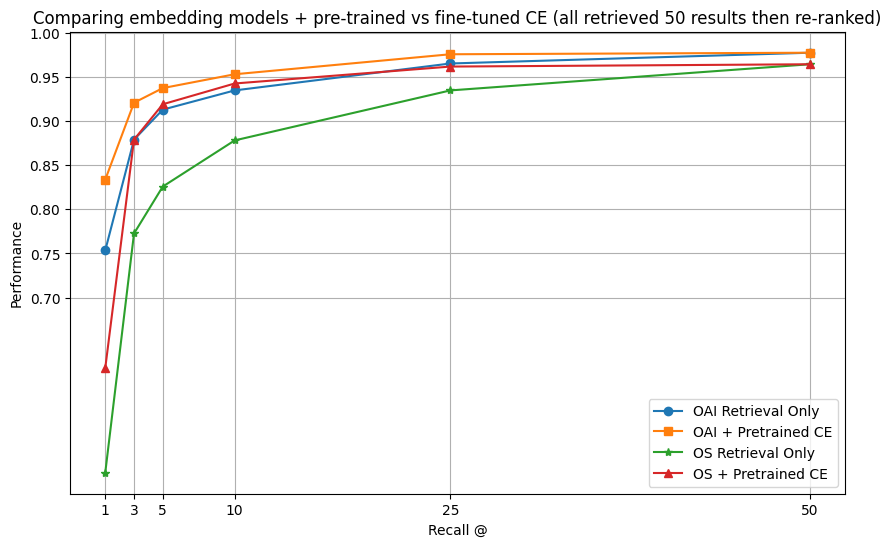

In [48]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(X, OPENAI_RETRIEVAL, label='OAI Retrieval Only', marker='o')
plt.plot(X, OLD_CROSS_ENCODER, label='OAI + Pretrained CE', marker='s')

plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='OS Retrieval Only', marker='*')
plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE, label='OS + Pretrained CE', marker='^')


# Adding titles and labels
plt.title('Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)')
plt.xlabel('Recall @')
plt.ylabel('Performance')
plt.xticks(X)
plt.yticks([i/100 for i in range(70, 101, 5)])  # Adjusting y-ticks to start from 0.75

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)

## Advanced: Fine-tuning the re-ranker

In [49]:
dataset['train'][0]

{'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
 'title': 'Area 51',
 'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its duty t

In [127]:
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader
from random import shuffle

In [128]:
unique_train_passages = list(set(dataset['train']['context']))
len(unique_train_passages), len(dataset['train']['context'])

(9916, 11590)

In [129]:
len(unique_train_passages), doc_emb.shape

(9916, (1148, 768))

In [133]:
# use sentence_transformers.util.semantic_search
train_doc_embed = bi_encoder.encode(unique_train_passages, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/310 [00:00<?, ?it/s]

In [134]:
unique_train_passages = np.array(unique_train_passages)

# Example usage
print(unique_train_passages[0])

find_most_similar(bi_encoder, unique_train_passages[0], train_doc_embed, unique_train_passages)

If two or more routers tie with the highest priority setting, the router sending the Hello with the highest RID (Router ID) wins. NOTE: a RID is the highest logical (loopback) IP address configured on a router, if no logical/loopback IP address is set then the router uses the highest IP address configured on its active interfaces (e.g. 192.168.0.1 would be higher than 10.1.1.2).


[('If two or more routers tie with the highest priority setting, the router sending the Hello with the highest RID (Router ID) wins. NOTE: a RID is the highest logical (loopback) IP address configured on a router, if no logical/loopback IP address is set then the router uses the highest IP address configured on its active interfaces (e.g. 192.168.0.1 would be higher than 10.1.1.2).',
  1.0000001192092896,
  0),
 ('OSPF supports complex networks with multiple routers, including backup routers, to balance traffic load on multiple links to other subnets. Neighboring routers in the same broadcast domain or at each end of a point-to-point link communicate with each other via the OSPF protocol. Routers form adjacencies when they have detected each other. This detection is initiated when a router identifies itself in a Hello protocol packet. Upon acknowledgment, this establishes a two-way state and the most basic relationship. The routers in an Ethernet or Frame Relay network select a Designa

In [158]:
# negative example mining
train_samples = []

for train_example in tqdm(dataset['train']):
    # train_samples.append(
    #         InputExample(
    #             texts=[train_example['question'], train_example['context']], label=1
    #         )
    #     )
    for i, (passage, score, corpus_idx) in enumerate(find_most_similar(bi_encoder, train_example['question'], train_doc_embed, unique_train_passages)):

        train_samples.append(
            InputExample(
                texts=[train_example['question'], passage], label=int(passage == train_example['context'])
            )
        )


shuffle(train_samples)


100%|██████████| 11590/11590 [03:46<00:00, 51.14it/s]


<Axes: >

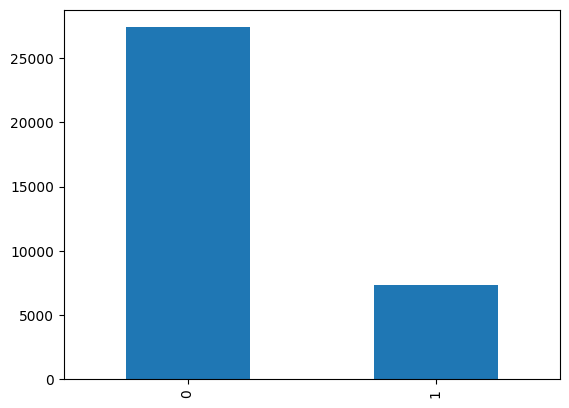

In [159]:
import pandas as pd
pd.Series([t.label for t in train_samples]).value_counts().plot(kind='bar')

In [160]:
dataset['train'][0]

{'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
 'title': 'Area 51',
 'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its duty t

In [161]:
train_samples[2].__dict__

{'guid': '',
 'texts': ['Whose oral histories are recorded?',
  "The story begins in 1885 with the arrival of an important new guest star in Buffalo Bill Cody's grand illusion, Chief Sitting Bull of Little Big Horn fame. Much to Cody's annoyance, Sitting Bull proves not to be a murdering savage but a genuine embodiment of what the whites believe about their own history out west. He is quietly heroic and morally pure."],
 'label': 0}

In [162]:
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryClassificationEvaluator
import math
import torch
from random import sample

logger.setLevel(logging.DEBUG)  # just to get some logs

num_epochs = 1

model_save_path = './fine_tuned_ir_cross_encoder'

train_dataloader = DataLoader(train_samples[:int(len(train_samples)*.8)], shuffle=True, batch_size=16)

# An evaluator for training performance
evaluator = CECorrelationEvaluator.from_input_examples(train_samples[int(len(train_samples)*.8):], name='test')

# Rule of thumb for warmup steps
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
print(f"Warmup-steps: {warmup_steps}")

Warmup-steps: 174


In [163]:
for t in train_samples:
    if t.label == 1:
        print('Example of label 1')
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break
for t in train_samples:
    if t.label == 0:
        print('Example of label 0')
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break

Example of label 1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['What are the Chrysopidae reared for?', 'While depending on species and environmental conditions, some green lacewings will eat only about 150 prey items in their entire life, in other cases 100 aphids will be eaten in a single week. Thus, in several countries, millions of such voracious Chrysopidae are reared for sale as biological control agents of insect and mite pests in agriculture and gardens. They are distributed as eggs, since as noted above they are highly aggressive and cannibalistic in confined quarters; the eggs hatch in the field. Their performance is variable; thus, there is interest in further research to improve the use of green lacewings as biological pest control. Species that have hitherto attracted wider study and are more or less readily available as captive-bred eggs to deposit out for hatching in pest-infested plant cultures are several members of Chrysoperla as well as Mallada signatus. They are a natural predator of the European corn bore

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['What was the name of the game that it was also used in?', 'The ancient Egyptians enjoyed a variety of leisure activities, including games and music. Senet, a board game where pieces moved according to random chance, was particularly popular from the earliest times; another similar game was mehen, which had a circular gaming board. “Hounds and Jackals” also known as 58 holes is another example of board games played in ancient Egypt. The first complete set of this game was discovered from a Theban tomb of the Egyptian pharaoh Amenemhat IV that dates to the 13th Dynasty. Juggling and ball games were popular with children, and wrestling is also documented in a tomb at Beni Hasan. The wealthy members of ancient Egyptian society enjoyed hunting and boating as well.'], 'label': 0} 0.23082681


In [164]:
evaluator(cross_encoder)

INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:CECorrelationEvaluator: Evaluating the model on test dataset:
INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:Correlation:	Pearson: 0.7488	Spearman: 0.6311


0.6311188898776826

In [165]:
# Train the model
from sentence_transformers import InputExample, losses, evaluation

# you may turn on debug for more logs here e.g. logger.setLevel(logging.DEBUG)
cross_encoder.fit(
    train_dataloader=train_dataloader,
    loss_fct=nn.BCEWithLogitsLoss(),  # this is the default loss if num_labels is 1 otherwise CrossEntropyLoss
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True
)

/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:233: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1739 [00:00<?, ?it/s]

INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:CECorrelationEvaluator: Evaluating the model on test dataset after epoch 0:
INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:Correlation:	Pearson: 0.7943	Spearman: 0.6685
INFO:sentence_transformers.cross_encoder.CrossEncoder:Save model to ./fine_tuned_ir_cross_encoder


In [166]:
evaluator(cross_encoder)

INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:CECorrelationEvaluator: Evaluating the model on test dataset:
INFO:sentence_transformers.cross_encoder.evaluation.CECorrelationEvaluator:Correlation:	Pearson: 0.7943	Spearman: 0.6685


0.6684536609137994

In [167]:
finetuned = CrossEncoder(model_save_path)

print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Sigmoid()))
print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Identity()))

INFO:sentence_transformers.cross_encoder.CrossEncoder:Use pytorch device: cuda


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11719599


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

-2.0192554


In [168]:
logger.setLevel(logging.CRITICAL)

ft_predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=finetuned, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    ft_predictions.append(r)
    if len(ft_predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

        print(f'Accuracy without re-ranking: {retrieved_accuracy}')
        print(f'Accuracy with re-ranking: {re_ranked_accuracy}')


  9%|▊         | 100/1148 [01:35<16:53,  1.03it/s]

Accuracy without re-ranking: 0.78
Accuracy with re-ranking: 0.92


 17%|█▋        | 200/1148 [03:12<15:03,  1.05it/s]

Accuracy without re-ranking: 0.765
Accuracy with re-ranking: 0.91


 26%|██▌       | 300/1148 [04:47<15:23,  1.09s/it]

Accuracy without re-ranking: 0.7666666666666667
Accuracy with re-ranking: 0.89


 35%|███▍      | 400/1148 [06:24<11:18,  1.10it/s]

Accuracy without re-ranking: 0.7625
Accuracy with re-ranking: 0.89


 44%|████▎     | 500/1148 [08:03<10:00,  1.08it/s]

Accuracy without re-ranking: 0.764
Accuracy with re-ranking: 0.896


 52%|█████▏    | 600/1148 [09:39<08:39,  1.05it/s]

Accuracy without re-ranking: 0.7683333333333333
Accuracy with re-ranking: 0.8966666666666666


 61%|██████    | 700/1148 [11:15<07:15,  1.03it/s]

Accuracy without re-ranking: 0.7471428571428571
Accuracy with re-ranking: 0.8842857142857142


 70%|██████▉   | 800/1148 [12:59<06:51,  1.18s/it]

Accuracy without re-ranking: 0.74875
Accuracy with re-ranking: 0.88375


 78%|███████▊  | 900/1148 [14:36<03:46,  1.09it/s]

Accuracy without re-ranking: 0.7377777777777778
Accuracy with re-ranking: 0.8866666666666667


 87%|████████▋ | 1000/1148 [16:13<02:43,  1.11s/it]

Accuracy without re-ranking: 0.74
Accuracy with re-ranking: 0.883


 96%|█████████▌| 1100/1148 [17:49<00:45,  1.06it/s]

Accuracy without re-ranking: 0.75
Accuracy with re-ranking: 0.8872727272727273


100%|██████████| 1148/1148 [18:35<00:00,  1.03it/s]


In [169]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7534843205574913
Accuracy with re-ranking: 0.8902439024390244


In [170]:
# Re-ranking got slightly better after 1 epoch

In [171]:
ft_predictions_df = pd.DataFrame(ft_predictions)
ft_predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone,top_re_rank_score
0,"[{'score': 0.27245408, 'id': '2f90090e21f19450...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '...",0.272454
1,"[{'score': 0.95008755, 'id': '49201636ad410273...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '...",0.950088
2,"[{'score': 0.9484397, 'id': '80d92494d2b06f341...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '...",0.948440
3,"[{'score': 0.32520765, 'id': 'e3fd54f33b021ea3...",0.0,0.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '...",0.325208
4,"[{'score': 0.4159641, 'id': '37ed40c20d4e1b9cc...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '...",0.415964


In [172]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].isnull().sum()

,0
retrieved_correct_position,25
reranked_correct_position,25


In [173]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()

,0
retrieved_correct_position,1.346394
reranked_correct_position,0.547640


In [174]:
# do recall @ 1, 3, 5, 10
OPENAI_RETRIEVAL = []
OPENAI_RETRIEVAL_PLUS_FT_CE = []
for k in X:
    embedding_only_recall = ft_predictions_df[ft_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = ft_predictions_df[ft_predictions_df['reranked_correct_position'] < k].shape[0]
    OPENAI_RETRIEVAL.append(embedding_only_recall / ft_predictions_df.shape[0])
    OPENAI_RETRIEVAL_PLUS_FT_CE.append(reranked_recall / ft_predictions_df.shape[0])
    print(k, embedding_only_recall, reranked_recall)

1 865 1022
3 1009 1083
5 1048 1090
10 1073 1104
25 1108 1117
50 1123 1123


In [175]:
logger.setLevel(logging.CRITICAL)
os_predictions = []

for i, question in tqdm(enumerate(test_sample), total=len(test_sample)):
    os_predictions.append(eval_ranking_open_source(bi_encoder, doc_emb, question['question'], top_k=TOP_K, re_rank_model=finetuned))

os_predictions_df = pd.DataFrame(os_predictions)
os_predictions_df.head()

100%|██████████| 1148/1148 [09:07<00:00,  2.10it/s]


,retrieved_correct_position,reranked_correct_position
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [176]:
raw_accuracy = sum([p['retrieved_correct_position'] == 0 for p in os_predictions])/len(os_predictions)
reranked_accuracy = sum([p['reranked_correct_position'] == 0 for p in os_predictions])/len(os_predictions)

print(f'Accuracy without re-ranking: {raw_accuracy}')
print(f'Accuracy with re-ranking: {reranked_accuracy}')


Accuracy without re-ranking: 0.5017421602787456
Accuracy with re-ranking: 0.6428571428571429


In [177]:
# do recall @ 1, 3, 5, 10
OPEN_SOURCE_RETRIEVAL = []
OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE = []
for k in X:
    embedding_only_recall = os_predictions_df[os_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = os_predictions_df[os_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)
    OPEN_SOURCE_RETRIEVAL.append(embedding_only_recall / os_predictions_df.shape[0])
    OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE.append(reranked_recall / os_predictions_df.shape[0])

1 576 738
3 887 1029
5 948 1072
10 1008 1091
25 1073 1103
50 1107 1107


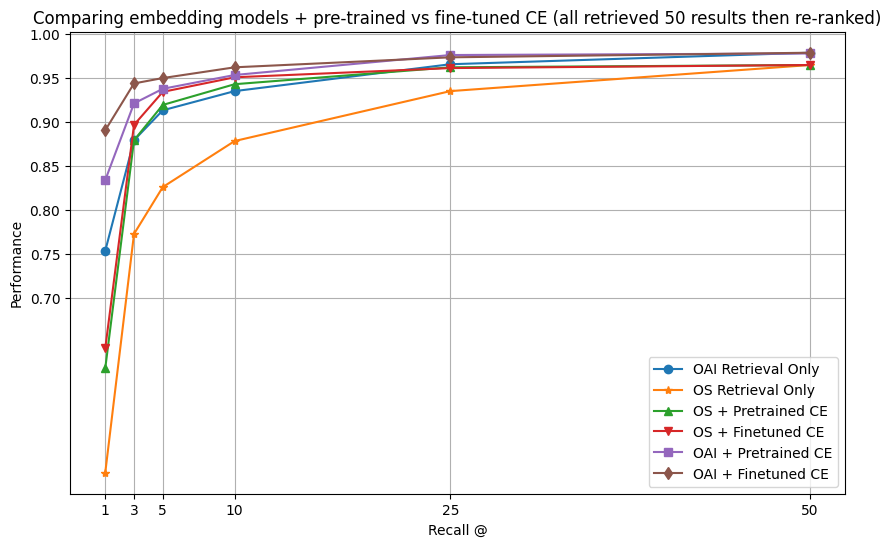

In [178]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(X, OPENAI_RETRIEVAL, label='OAI Retrieval Only', marker='o')
plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='OS Retrieval Only', marker='*')
plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_PRE_CE, label='OS + Pretrained CE', marker='^')

plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE, label='OS + Finetuned CE', marker='v')
plt.plot(X, OLD_CROSS_ENCODER, label='OAI + Pretrained CE', marker='s')
plt.plot(X, OPENAI_RETRIEVAL_PLUS_FT_CE, label='OAI + Finetuned CE', marker='d')

# Adding titles and labels
plt.title('Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)')
plt.xlabel('Recall @')
plt.ylabel('Performance')
plt.xticks(X)
plt.yticks([i/100 for i in range(70, 101, 5)])  # Adjusting y-ticks to start from 0.75

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
# plt.show()

plt.savefig('recall_at_k.png', dpi=1000)

In [181]:
# show results as a table

results_df = pd.DataFrame({'RECALL @': [1, 3, 5, 10, 25, 50], 'OS_Retrieval_Only': OPEN_SOURCE_RETRIEVAL, 'OS_Retrieval_Plus_Finetuned_CE': OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE   , 'OAI_Retrieval_Only': OPENAI_RETRIEVAL    , 'OAI_Retrieval_Plus_Pretrained_CE': OLD_CROSS_ENCODER, 'OAI_Retrieval_Plus_Finetuned_CE': OPENAI_RETRIEVAL_PLUS_FT_CE})
results_df.sort_values(by='RECALL @')

,RECALL @,OS_Retrieval_Only,OS_Retrieval_Plus_Finetuned_CE,OAI_Retrieval_Only,OAI_Retrieval_Plus_Pretrained_CE,OAI_Retrieval_Plus_Finetuned_CE
0,1,0.501742,0.642857,0.753484,0.833624,0.890244
1,3,0.772648,0.896341,0.878920,0.920732,0.943380
2,5,0.825784,0.933798,0.912892,0.937282,0.949477
3,10,0.878049,0.950348,0.934669,0.952962,0.961672
4,25,0.934669,0.960801,0.965157,0.975610,0.972997
5,50,0.964286,0.964286,0.978223,0.977352,0.978223


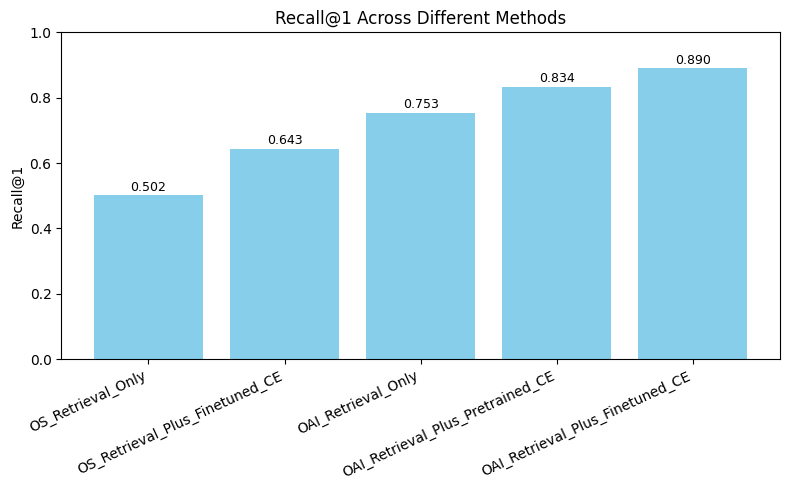

In [1]:
import matplotlib.pyplot as plt

# Data
methods = [
    "OS_Retrieval_Only",
    "OS_Retrieval_Plus_Finetuned_CE",
    "OAI_Retrieval_Only",
    "OAI_Retrieval_Plus_Pretrained_CE",
    "OAI_Retrieval_Plus_Finetuned_CE"
]

recalls = [0.501742, 0.642857, 0.753484, 0.833624, 0.890244]

# Create a bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, recalls, color="skyblue")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

# Labeling and aesthetics
plt.title("Recall@1 Across Different Methods")
plt.ylabel("Recall@1")
plt.xticks(rotation=25, ha="right")  # Rotate x-axis labels if needed
plt.ylim([0, 1])                    # Since recall values typically range [0,1]
plt.tight_layout()

# Display the plot
plt.show()
